In [121]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [122]:
df = pd.read_csv('network_data.csv')
df

,source_ip,destination_ip,source_port,destination_port,packet_length,protocol,timestamp,label
0,192.168.1.103,10.0.0.161,13278,17197,711,UDP,01/01/2021 00:00,benign
1,192.168.1.180,10.0.0.245,52884,60913,1266,UDP,01/01/2021 00:00,malicious
2,192.168.1.93,10.0.0.212,12368,28011,1211,UDP,01/01/2021 00:00,malicious
3,192.168.1.15,10.0.0.205,2774,14202,983,TCP,01/01/2021 00:00,malicious
4,192.168.1.107,10.0.0.220,55780,40362,238,UDP,01/01/2021 00:00,malicious
...,...,...,...,...,...,...,...,...
995,192.168.1.155,10.0.0.62,44814,31706,1165,UDP,01/01/2021 00:16,benign
996,192.168.1.246,10.0.0.80,9258,33286,255,TCP,01/01/2021 00:16,malicious
997,192.168.1.191,10.0.0.216,26543,61509,598,TCP,01/01/2021 00:16,malicious
998,192.168.1.145,10.0.0.83,27990,32382,198,TCP,01/01/2021 00:16,benign


# Remove features with no predictive power

In [123]:
df.drop(['timestamp'], axis=1, inplace=True)
df

,source_ip,destination_ip,source_port,destination_port,packet_length,protocol,label
0,192.168.1.103,10.0.0.161,13278,17197,711,UDP,benign
1,192.168.1.180,10.0.0.245,52884,60913,1266,UDP,malicious
2,192.168.1.93,10.0.0.212,12368,28011,1211,UDP,malicious
3,192.168.1.15,10.0.0.205,2774,14202,983,TCP,malicious
4,192.168.1.107,10.0.0.220,55780,40362,238,UDP,malicious
...,...,...,...,...,...,...,...
995,192.168.1.155,10.0.0.62,44814,31706,1165,UDP,benign
996,192.168.1.246,10.0.0.80,9258,33286,255,TCP,malicious
997,192.168.1.191,10.0.0.216,26543,61509,598,TCP,malicious
998,192.168.1.145,10.0.0.83,27990,32382,198,TCP,benign


# Convert source_ip, and destination_ip to a reasonable hash value

In [124]:
import socket
import struct

def ip_to_int(ip):
    """Convert a dot-decimal IP address string to an integer."""
    return struct.unpack("!I", socket.inet_aton(ip))[0]

In [125]:
for col in ['source_ip', 'destination_ip']:
    df[col] = df[col].apply(ip_to_int)

df.head()

,source_ip,destination_ip,source_port,destination_port,packet_length,protocol,label
0,3232235879,167772321,13278,17197,711,UDP,benign
1,3232235956,167772405,52884,60913,1266,UDP,malicious
2,3232235869,167772372,12368,28011,1211,UDP,malicious
3,3232235791,167772365,2774,14202,983,TCP,malicious
4,3232235883,167772380,55780,40362,238,UDP,malicious


# Apply OHE to the protocols

In [126]:
from sklearn.preprocessing import OneHotEncoder

ohe_proto = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_proto = ohe_proto.fit_transform(df[['protocol']])
proto_feature_names = ohe_proto.get_feature_names_out(['protocol'])
proto_df = pd.DataFrame(encoded_proto, columns=proto_feature_names, index=df.index)
df = pd.concat([df.drop(['protocol'], axis=1), proto_df], axis=1)

df

,source_ip,destination_ip,source_port,destination_port,packet_length,label,protocol_TCP,protocol_UDP
0,3232235879,167772321,13278,17197,711,benign,0.0,1.0
1,3232235956,167772405,52884,60913,1266,malicious,0.0,1.0
2,3232235869,167772372,12368,28011,1211,malicious,0.0,1.0
3,3232235791,167772365,2774,14202,983,malicious,1.0,0.0
4,3232235883,167772380,55780,40362,238,malicious,0.0,1.0
...,...,...,...,...,...,...,...,...
995,3232235931,167772222,44814,31706,1165,benign,0.0,1.0
996,3232236022,167772240,9258,33286,255,malicious,1.0,0.0
997,3232235967,167772376,26543,61509,598,malicious,1.0,0.0
998,3232235921,167772243,27990,32382,198,benign,1.0,0.0


In [127]:
df['label'] = (df['label'] == 'benign').astype(int)
df

,source_ip,destination_ip,source_port,destination_port,packet_length,label,protocol_TCP,protocol_UDP
0,3232235879,167772321,13278,17197,711,1,0.0,1.0
1,3232235956,167772405,52884,60913,1266,0,0.0,1.0
2,3232235869,167772372,12368,28011,1211,0,0.0,1.0
3,3232235791,167772365,2774,14202,983,0,1.0,0.0
4,3232235883,167772380,55780,40362,238,0,0.0,1.0
...,...,...,...,...,...,...,...,...
995,3232235931,167772222,44814,31706,1165,1,0.0,1.0
996,3232236022,167772240,9258,33286,255,0,1.0,0.0
997,3232235967,167772376,26543,61509,598,0,1.0,0.0
998,3232235921,167772243,27990,32382,198,1,1.0,0.0


# Draw diagrams for each feature and their relationship with the label

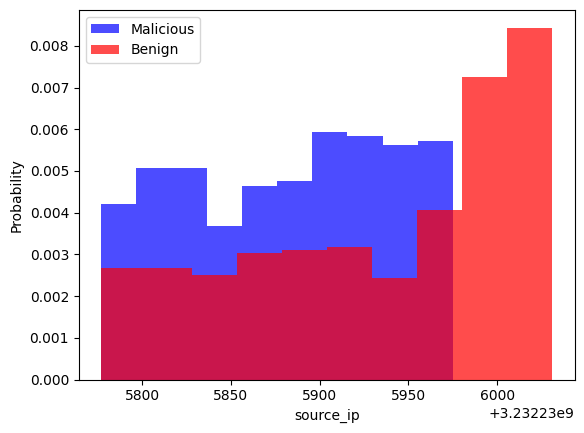

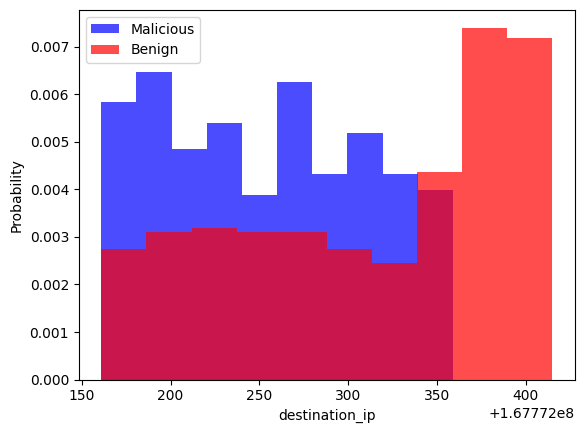

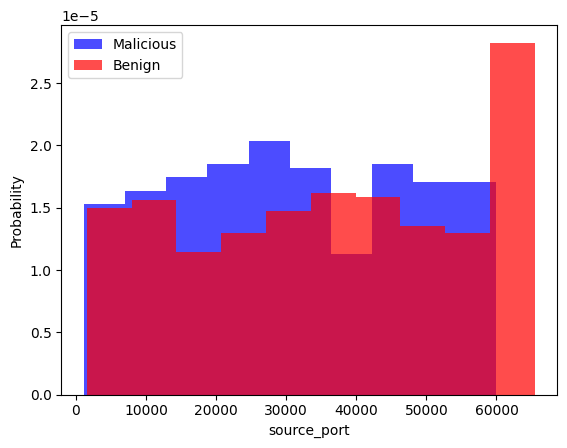

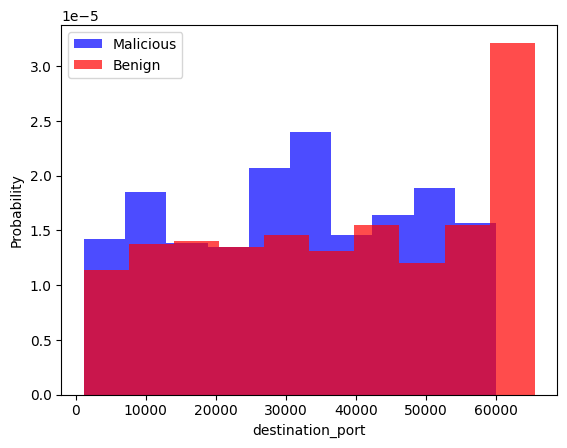

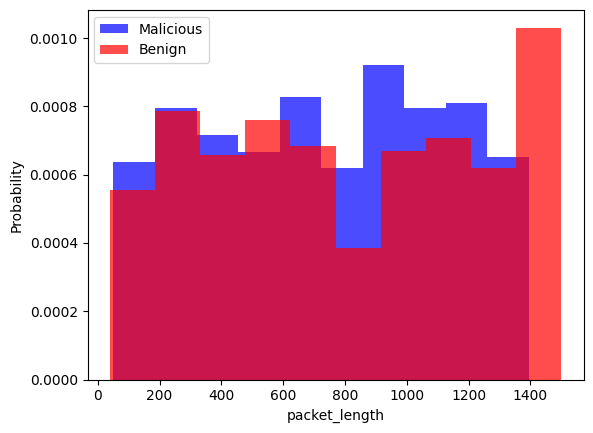

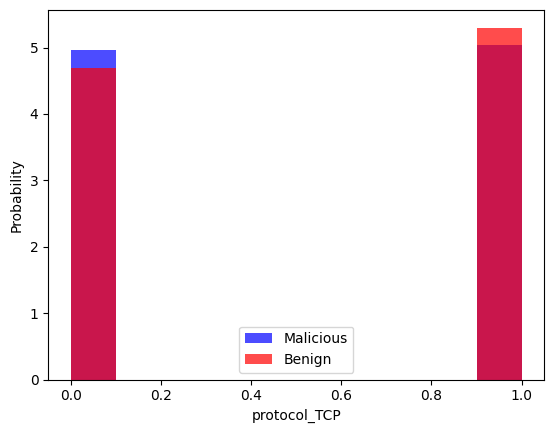

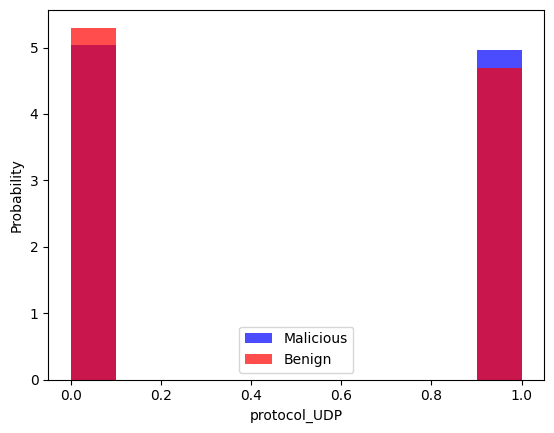

In [128]:
copy_df = df.copy()
copy_df.drop('label', axis=1, inplace=True)

for col in copy_df.columns:
  plt.hist(df[df['label'] == 1][col], alpha=0.7, label='Malicious', color='blue', density=True)
  plt.hist(df[df['label'] == 0][col], alpha=0.7, label='Benign', color='red', density=True)
  plt.legend()
  plt.ylabel('Probability')
  plt.xlabel(col)
  plt.show()

# Prepare train, test, valid data

In [129]:
train, test, valid = np.split(df.sample(frac=1), [int(0.6 * len(df)), int(0.8 * len(df))])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [130]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

def scale_dataset(dataframe, oversample=False, save_scaler_path=None):
    y = dataframe['label'].values
    X = dataframe.drop('label', axis=1).values

    # Fit and transform the data
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X))

    # Save the fitted scaler
    if save_scaler_path:
        with open(save_scaler_path, 'wb') as f:
            pickle.dump(scaler, f)

    # Oversample if requested
    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)

    data = np.hstack((X, np.reshape(y, (-1, 1))))

    return data, X, y

In [132]:
train, X_train, y_train = scale_dataset(train, oversample=True, save_scaler_path='scaler.pkl')
test, X_test, y_test = scale_dataset(test, oversample=False)
valid, X_valid, y_valid = scale_dataset(valid, oversample=False)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


# Random Forest Classification

In [133]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       111
           1       0.92      0.97      0.95        89

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



In [134]:
import pickle

with open('rf_model.pkl', 'wb') as f:
  pickle.dump(rf_model, f)

In [135]:
print(y_test)
print(X_test)

[0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 0 1
 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1
 1 0 0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0
 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 1 0 1
 1 1 0 0 0 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0
 0 1 1 0 1 1 0 0 1 0 0 1 1 0 0]
            0         1         2         3         4         5         6
0    1.058207  1.749829  1.317717 -1.584887 -1.434903 -1.010051  1.010051
1    0.858971  1.238164  1.617007  0.154356 -1.064155  0.990050 -0.990050
2    0.394088  0.147508  1.615725  1.077925  1.424137  0.990050 -0.990050
3   -0.203619  0.147508 -0.935974 -1.244726  1.015363 -1.010051  1.010051
4    0.287829  0.147508  0.647173 -1.216137 -0.802729 -1.010051  1.010051
..        ...       ...       ...       ...       ...       ...       ...
195 -0.190336  1.628645  0.981217 -0.913288 -0.175309  0.990050 -0.990050
1